# Chainer v4 ビギナー向けチュートリアル

## インストール

Chainerのインストールはとても簡単です。Chainer本体はすべてPythonコードのみからなるので、インストールも

%%cmd
pip install chainer

で完了です。ただ、これだけではGPUは使えません。GPUを使うためには、別途CuPyをインストールする必要があります。ただCuPyのインストールもとても簡単です。

%%cmd
pip install cupy-cuda90

以上です。筆者の環境がCUDA9.0の環境であったためcupy-cuda90をインストールしていますが、この末尾の2つの数字はCUDAのバージョンを表しています。お使いの環境のCUDAバージョンに合わせて、

* cupy-cuda80（CUDA 8.0用）
* cupy-cuda90（CUDA9.0用）
* cupy-cuda91（CUDA9.1用）

の3つから適切なものを選択してpip installしてください。CuPy v4.0.0からwheelでのインストールが可能となりましたので、これにより自動的にcuDNNやNCCL2といったライブラリもインストールされ、CuPyから使用可能になります。（cuDNNを独立に取ってくる方法を注に書いておきます1）

以下のチュートリアルでは、matplotlibを可視化に使いますので、これも同時にインストールしておきましょう。

%%cmd 

pip install matplotlib

また、計算グラフの可視化にGraphvizを使いますので、こちらもインストールしておいてください。

## 学習ループを書いてみる

ここでは、有名な手書き数字のデータセットMNISTを使って、画像を10クラスに分類するネットワークを書いて訓練してみます。

### 1.データセットの準備

教師あり学習の場合、データセットは「入力データ」と「それと対になるラベルデータ」を返すオブジェクトである必要があります。
ChainerにはMNISTやCIFAR10/100のようなよく用いられるデータセットに対して、データをダウンロードしてくるところからそのような機能をもったオブジェクトを作るところまで自動的にやってくれる便利なメソッドがあるので、ここではひとまずこれを用いましょう。

In [2]:
from chainer.datasets import mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

データセットオブジェクト自体は準備ができました。これは、例えば train_val[i] などとするとi番目の (data, label) というタプルを返すリスト と同様のものになっています（実際ただのPythonリストもChainerのデータセットオブジェクトとして使えます）。では0番目のデータとラベルを取り出して、表示してみましょう。

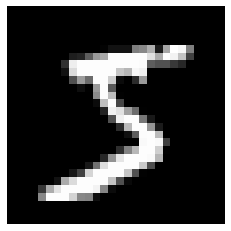

label: 5


In [3]:
# matplotlibを使ったグラフ描画結果がnotebook内に表示されるようにします。
%matplotlib inline
import matplotlib.pyplot as plt

# データの例示
x, t = train_val[0]  # 0番目の (data, label) を取り出す
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print('label:', t)

#### 1.1 Validation(検証)用データセットを作る

次に、上で作成したtrain_valデータセットを、Training用のデータセットとValidation用のデータセットに分割しましょう。これもChainerの便利な関数を使えば簡単にできます。元々60000個のデータが入っているtrainデータセット50000個のデータをTraining用に、残りの10000個をValidation用にしてみます。

In [4]:
from chainer.datasets import split_dataset_random

train, valid = split_dataset_random(train_val, 50000, seed=0)

これだけで元々のtrain_valを、ランダムに選んだ50000個のtrainデータセットとvalidデータセットに分けることができました。何度も実行する際に異なる分け方になってしまわないよう、第3引数のseedを設定しておくことをオススメします。それでは、それぞれのデータセットの中に入っているデータの数を確認してみましょう。

In [5]:
print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))

Training dataset size: 50000
Validation dataset size: 10000


### 3. Iteratorの作成

データセットの準備は完了しましたが、このままネットワークの学習に使うのは少し面倒です。なぜなら、ネットワークのパラメータ最適化手法として広く用いられているStochastic Gradient Descent (SGD)という手法では、一般的にいくつかのデータを束ねたミニバッチと呼ばれる単位でネットワークにデータを渡し、それに対する予測を作って、ラベルと比較するということを行います。そのため、バッチサイズ分だけデータとラベルを束ねる作業が必要です。

そこで、データセットから決まった数のデータとラベルを取得し、それらを束ねてミニバッチを作ってくれる機能を持ったIteratorを使いましょう。Iteratorは、先程作ったデータセットオブジェクトを渡して初期化してやったあとは、next()メソッドで新しいミニバッチを返してくれます。内部ではデータセットを何周なめたか（epoch）などの情報がどうように記録されているおり、学習ループを書いていく際に便利です。

データセットオブジェクトからイテレータを作るには、以下のようにします。

In [6]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

ここでは、学習に用いるデータセット用のイテレータ（train_iter）と、検証用のデータセット用のイテレータ（valid_iter）、および学習したネットワークの評価に用いるテストデータセット用のイテレータ（test_iter）の計3つを作成しています。ここで、batchsize = 128としているので、作成した3つのIteratorは、例えばtrain_iter.next()などとすると128枚の数字画像データを一括りにして返してくれます。

**NOTE:SerialIteratorについて**
Chainerがいくつか用意しているIteratorの一種であるSerialIteratorは、データセットの中のデータを順番に取り出してくる最もシンプルなIteratorです。コンストラクタの引数にデータセットオブジェクトと、バッチサイズを取ります。このとき、渡したデータセットオブジェクトから、何周も何周もデータを繰り返し読み出す必要がある場合はrepeat引数をTrueとし、1周が終わったらそれ以上データを取り出したくない場合はこれをFalseとします。これは、主にvalidation用のデータセットに対して使うフラグです。デフォルトでは、Trueになっています。また、shuffle引数にTrueを渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更します。SerialIteratorの他にも、マルチプロセスで高速にデータを処理できるようにしたMultiprocessIteratorやMultithreadIteratorなど、複数のIteratorが用意されています。詳しくは以下を見てください。

[Chainerで使えるIterator一覧](https://docs.chainer.org/en/stable/reference/iterators.html)

### 3. ネットワークの定義

では、学習させるネットワークを定義してみましょう。今回は、全結合層のみからなる多層パーセプトロンを作ってみます。中間層のユニット数は適当に100とし、今回は10クラス分類をしたいので、出力ユニット数は10とします。今回用いるMNISTデータセットは0〜9までの数字のいずれかを意味する10種のラベルを持つためです。では、ネットワークを定義するために必要なLink, Function, そしてChainについて、簡単にここで説明を行います。

**LinkとFunction**

Chainerでは、ニューラルネットワークの各層を、LinkとFunctionに区別します。

* Linkは、パラメータを持つ関数です。
* Functionは、パラメータを持たない関数です。

これらを組み合わせてネットワークを記述します。パラメータを持つ層は、chainer.linksモジュール以下にたくさん用意されています。パラメータを持たない層は、chainer.functionsモジュール以下にたくさん用意されています。これらに簡単にアクセスするために、

In [7]:
import chainer.links as L
import chainer.functions as F

と別名を与えて、L.Convolution2D(...)やF.relu(...)のように用いる慣習がありますが、特にこれが決まった書き方というわけではありません。

**Chain**

Chainは、パラメータを持つ層（Link）をまとめておくためのクラスです。パラメータを持つということは、基本的にネットワークの学習の際にそれらを更新していく必要があるということです（更新されないパラメータを持たせることもできます）。Chainerでは、モデルのパラメータの更新は、Optimizerという機能が担います。その際、更新すべき全てのパラメータを簡単に発見できるように、Chainで一箇所にまとめておきます。そうすると、Chain.params()メソッドを使って更新されるパラメータ一覧が簡単に取得できます。


**Chainを継承してネットワークを定義しよう**

Chainerでは、ネットワークはChainクラスを継承したクラスとして定義されることが一般的です。その場合、そのクラスのコンストラクタで、self.init_scope()で作られるwithコンテキストを作り、その中でネットワークに登場するLinkをプロパティとして登録しておきます。こうすると、自動的にOptimizerが最適化対象のパラメータを持つ層だな、と捉えてくれます。

もう一つ、一般的なのは、ネットワークの前進計算（データを渡して、出力を返す）を、__call__メソッドに書いておくという方法です。こうすると、ネットワーククラスをinstantiateして作ったオブジェクトを、関数のようにして使うことができます（例：output = net(data)）。


**GPUで実行するには**

Chainクラスはto_gpuメソッドを持ち、この引数にGPU IDを指定すると、指定したGPU IDのメモリ上にネットワークの全パラメータを転送します。こうしておくと、前進計算も学習の際のパラメータ更新なども全部GPU上で行われるようになります。GPU IDとして-1を使うと、すなわちこれはCPUを意味します。

**同じ結果を保証したい**

ネットワークを書き始める前に、まずは乱数シードを固定して、本記事とほぼ同様の結果が再現できるようにしておきましょう。（cuDNNが有効になっている環境下でより厳密に計算結果の再現性を保証したい場合は、chainer.config.cudnn_deterministicというConfiguringオプションについて知る必要があります。こちらのドキュメントを参照してください：[chainer.config.cudnn_deterministic](https://docs.chainer.org/en/stable/reference/configuration.html?highlight=chainer.config.cudnn_deterministic)

In [8]:
import random
import numpy
import chainer

def reset_seed(seed=0):
    random.seed(seed)
    numpy.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(0)

**ネットワークを表すコード**

いよいよネットワークを書いてみます！

In [9]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()

        # パラメータを持つ層の登録
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = -1  # CPUを用いる場合は、この値を-1にしてください
# gpu_id = 0 # GPUを用いる場合は、この行を有効にする

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

できました！疑問点はありませんか？ちなみに、Chainerにはたくさんの学習可能なレイヤやパラメータを持たないレイヤが用意されています。ぜひ一度以下の一覧のページを見てみましょう。

* [Chainerで使える関数(Function)一覧](https://docs.chainer.org/en/stable/reference/functions.html)
* [Chainerで学習できるレイヤ(Link)一覧](https://docs.chainer.org/en/stable/reference/links.html)

Link一覧には、ニューラルネットワークによく用いられる全結合層や畳み込み層、LSTMなどや、ReLUなどの活性化関数などなどだけでなく、有名なネットワーク全体もLinkとして載っています。ResNetや、VGGなどです。また、Function一覧には、画像の大きさをresizeしたり、サイン・コサインのような関数を始め、いろいろなネットワークの要素として使える関数が載っています。


**NOTE**

上のネットワーク定義で、L.Linearは全結合層を意味しますが、最初のLinear層は第一引数にNoneが渡されています。これは、実行時に、つまりデータがその層に入力された瞬間、必要な数の入力側ユニット数を自動的に計算するということを意味します。ネットワークが最初に計算を行う際に、初めて (n_input) ×× n_mid_units の大きさの行列を作成し、それを学習対象とするパラメータとして保持します。これは後々、畳み込み層を全結合層の前に配置する際などに便利な機能です。

様々なLinkは、それぞれ学習対象となるパラメータを保持しています。それらの値は、NumPyの配列として簡単に取り出して見ることができます。例えば、上のモデルMLPはl1という名前の全結合層が登録されています。この全結合層は重み行列Wとバイアスbという2つのパラメータを持ちます。これらには外から以下のようにしてアクセスすることができます：

In [10]:
print('1つ目の全結合層のバイアスパラメータの形は、', net.l1.b.shape)
print('初期化直後のその値は、', net.l1.b.array)

1つ目の全結合層のバイアスパラメータの形は、 (100,)
初期化直後のその値は、 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


しかしここで、net.l1.W.arrayの中身を同様に表示してみようとすると、Noneが返されます。

In [11]:
print(net.l1.W.array)

None


なぜでしょうか？我々はl1をネットワークに登録するときに、L.Linearの第一引数にNoneを渡しましたね。そして、まだネットワークに一度もデータを入力していません。そのため、まだ重み行列Wは作成されていません。そのため、まだnet.l1.Wは具体的な配列を保持していないのです。

### 4. 最適化手法の選択

では、上で定義したネットワークをMNISTデータセットを使って訓練してみましょう。学習時に用いる最適化の手法としてはいろいろな種類のものが提案されていますが、Chainerは多くの手法を同一のインターフェースで利用できるよう、Optimizerという機能でそれらを提供しています。chainer.optimizersモジュール以下に色々なものを見つけることができます。一覧はこちらにあります：

* [Chainerで使える最適化手法一覧](https://docs.chainer.org/en/stable/reference/optimizers.html)

ここでは最もシンプルな勾配降下法の手法であるoptimizers.SGDを用います。Optimizerのオブジェクトには、setupメソッドを使ってモデル（Chainオブジェクト）を渡します。こうすることでOptimizerに、何を最適化すればいいか把握させることができます。

他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下のchainer.optimizers.SGDのうちSGDの部分をMomentumSGD, RMSprop, Adamなどに変えるだけで、最適化手法の違いがどのような学習曲線（ロスカーブ）の違いを生むかなどを簡単に調べることができます。

In [12]:
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01).setup(net)

**NOTE**

今回はSGDのコンストラクタのlrという引数に 0.010.01 を与えました。この値は学習率として知られ、モデルをうまく訓練して良いパフォーマンスを発揮させるために調整する必要がある重要なハイパーパラメータとして知られています。

### 5. 学習する

いよいよ学習をスタートします！今回は分類問題なので、softmax_cross_entropyというロス関数を使って最小化すべきロスの値を計算します。

まず、ネットワークにデータを渡して、出てきた出力と、入力データに対応する正解ラベルを、Functionの一種でありスカラ値を返すロス関数に渡し、ロス（最小化したい値）の計算を行います。ロスは、chainer.Variableのオブジェクトになっています。そして、このVariableは、今まで自分にどんな計算が施されたかを辿れるようになっています。この仕組みが、Define-by-Run [Tokui 2015]とよばれる発明の中心的な役割を果たしています。

ここでは誤差逆伝播法自体の説明は割愛しますが、計算したロスに対する勾配をネットワークに逆向きに流していく処理は、Chainerではネットワークが吐き出したVariableが持つbackward()メソッドを呼ぶだけでできます。これを呼ぶと、前述のようにこれまでの計算過程を逆向きに遡って誤差逆伝播用の計算グラフを構築し、途中のパラメータの勾配を連鎖率を使って計算してくれます。

こうして計算された各パラメータに対する勾配を使って、先程Optimizerを作成する際に指定したアルゴリズムを使ってネットワークパラメータの更新（＝学習）が行われるわけです。

まとめると、今回1回の更新処理の中で行うのは、以下の4項目です。

1. ネットワークにデータを渡して出力yを得る
2. 出力yと正解ラベルtを使って、最小化すべきロスの値をsoftmax_cross_entropy関数で計算する
3. softmax_cross_entropy関数の出力（Variable）のbackward()メソッドを呼んで、ネットワークの全てのパラメータの勾配を誤差逆伝播法で計算する
4. Optimizerのupdateメソッドを呼び、3.で計算した勾配を使って全パラメータを更新する

パラメータの更新は、何度も何度も繰り返し行います。一度の更新に用いられるデータは、ネットワークに入力されたバッチサイズ分だけ束ねられたデータのみです。そのため、データセット全体のデータを使うために、次のミニバッチを入力して再度更新、その次のミニバッチを使ってまた更新、ということを繰り返すわけです。そのため、この過程を学習ループと呼んでいます。


**NOTE:ロス関数**

ちなみに、ロス関数は、例えば分類問題ではなく簡単な回帰問題を解きたいような場合、F.softmax_cross_entropyの代わりにF.mean_squared_errorなどを用いることもできます。他にも、いろいろな問題設定に対応するために様々なロス関数がChainerには用意されています。こちらからその一覧を見ることができます：

* [Chainerで使えるロス関数一覧](https://docs.chainer.org/en/stable/reference/functions.html#loss-functions)

**学習ループのコード**

In [13]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:

    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)

    # 予測値の計算
    y = net(x)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    # 勾配の計算
    net.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        valid_losses = []
        valid_accuracies = []
        while True:
            valid_batch = valid_iter.next()
            x_valid, t_valid = concat_examples(valid_batch, gpu_id)

            # Validationデータをforward
            with chainer.using_config('train', False), \
                    chainer.using_config('enable_backprop', False):
                y_valid = net(x_valid)

            # ロスを計算
            loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
            valid_losses.append(to_cpu(loss_valid.array))

            # 精度を計算
            accuracy = F.accuracy(y_valid, t_valid)
            accuracy.to_cpu()
            valid_accuracies.append(accuracy.array)

            if valid_iter.is_new_epoch:
                valid_iter.reset()
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(valid_losses), np.mean(valid_accuracies)))

# テストデータでの評価
test_accuracies = []
while True:
    test_batch = test_iter.next()
    x_test, t_test = concat_examples(test_batch, gpu_id)

    # テストデータをforward
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        y_test = net(x_test)

    # 精度を計算
    accuracy = F.accuracy(y_test, t_test)
    accuracy.to_cpu()
    test_accuracies.append(accuracy.array)

    if test_iter.is_new_epoch:
        test_iter.reset()
        break

print('test_accuracy:{:.04f}'.format(np.mean(test_accuracies)))

epoch:01 train_loss:0.9783 val_loss:0.9085 val_accuracy:0.8069
epoch:02 train_loss:0.4774 val_loss:0.5198 val_accuracy:0.8669
epoch:03 train_loss:0.4596 val_loss:0.4213 val_accuracy:0.8852
epoch:04 train_loss:0.3517 val_loss:0.3740 val_accuracy:0.8962
epoch:05 train_loss:0.2328 val_loss:0.3461 val_accuracy:0.9023
epoch:06 train_loss:0.2350 val_loss:0.3282 val_accuracy:0.9055
epoch:07 train_loss:0.3187 val_loss:0.3131 val_accuracy:0.9100
epoch:08 train_loss:0.2126 val_loss:0.2982 val_accuracy:0.9157
epoch:09 train_loss:0.4401 val_loss:0.2887 val_accuracy:0.9160
epoch:10 train_loss:0.2923 val_loss:0.2785 val_accuracy:0.9200
test_accuracy:0.9228


val_accuracyに着目してみると、最終的におおよそ92%程度の精度で手書きの数字が分類できるようになりました。学習終了後に、ループの中でValidationデータセットを使ってモデルの汎化性能をおおまかにチェックしているのと同様にして、テスト用のデータセットを用いて学習が終了したネットワークの評価を行っています。テストデータでの評価結果は、およそ93.75%の正解率となりました。

#### 5.1 ValidationやTestを行う際の注意点

ここで、ValidationにせよTestにせよ、「評価」を行う際には注意すべき点があります。学習は行わない、評価のためだけのデータをネットワークに渡して出力を計算している部分（例えば、y_test = net(x_test)）では、それらの行を2つのコンテキストでくくっています。

chainer.using_config('train', False)
まず、今回は学習時と推論時で動作が異なる関数は含まれていないため、実際の効力は持ちませんが、Validationやテストのために推論を行うときはchainer.config.train = Falseとします。以下のように、chainer.using_config('train', False)をwith構文と共に使えば、その中ではchainer.config.train = Falseとなります。

**with chainer.using_config('train', False):
    --- 何か推論処理 ---
    
これは、以下のようにするのと同じことです。

**chainer.config.train = False

**--- 何か推論処理 ---

ただし、Pythonのコンテキストを利用しない場合は、一度このようにどこかで書くと、それ以降この設定はグローバルにずっと有効になることに注意してください。（推論したあと再び学習を行うという場合は、再度chainer.config.train = Trueなどのようにすることが必要になります。chainer.config以下の規定の値に何かを代入することはグローバルに作用しますので、次に説明するenable_backpropについても同様です。）

chainer.using_config('enable_backprop', False)
次に、今回は評価に用いる出力の計算後にロス関数の各パラメータについての勾配は必要ないので、内部に計算グラフを保持しておく必要もないため、chainer.using_config('enable_backprop', False)として無駄な計算グラフの構築を行わないようにし、メモリ消費量を節約しています。

**NOTE:ChainerのConfig**

Chainerにはこの他にも、いくつかのグローバルなConfigがプリセットとして用意されています。また、chainer.config以下にユーザが自由な設定値を置くこともできます。詳しくはこちらを一読してください：[Configuring Chainer](https://docs.chainer.org/en/stable/reference/configuration.html)

### 6. 学習済みモデルを保存する

学習が終わったら、その結果を保存します。Chainerには、2種類のフォーマットで学習済みネットワークをシリアライズする機能が用意されています。一つはHDF5形式で、もう一つはNumPyのNPZ形式でネットワークを保存するものです。今回は、追加ライブラリのインストールが必要なHDF5ではなく、NumPy標準機能で提供されているシリアライズ機能（numpy.savez()）を利用したNPZ形式でのモデルの保存を行います。

In [14]:
from chainer import serializers

serializers.save_npz('my_mnist.model', net)

In [15]:
# ちゃんと保存されていることを確認
%ls -la my_mnist.model

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は 9EC4-CE97 です

 C:\Python\MyStudy\NN\Chainer のディレクトリ


 C:\Python\MyStudy\NN\Chainer のディレクトリ

2019/10/10  10:44           334,008 my_mnist.model
               1 個のファイル             334,008 バイト
               0 個のディレクトリ  152,036,638,720 バイトの空き領域


### 7. 保存したモデルを読み込んで推論する

学習したネットワークを、それを使って数字の分類がしたい誰かに渡して、使ってもらうにはどうしたら良いでしょうか。もっともシンプルな方法は、ネットワークの定義がかかれたPythonファイルと、今しがた保存したNPZファイルを渡して、以下のように使うことです。以下のコードの前に、渡したネットワーク定義のファイルからネットワークのクラス（ここではMLP）が読み込まれていることを前提とします。

In [16]:
# まず同じネットワークのオブジェクトを作る
infer_net = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', infer_net)

以上で準備が整いました。それでは、試しにテストデータの中から一つ目の画像を取ってきて、それに対する分類を行ってみましょう。

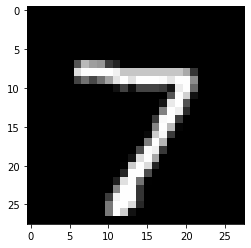

元の形： (784,) -> ミニバッチの形にしたあと： (1, 784)
ネットワークの予測: 7


In [17]:
gpu_id = -1  # CPUで計算をしたい場合は、-1を指定してください
# gpu_id = 0 # GPUで計算したい場合は、この行を有効にする

if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)

# 1つ目のテストデータを取り出します
x, t = test[0]  #  tは使わない

# どんな画像か表示してみます
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()

# ミニバッチの形にする（複数の画像をまとめて推論に使いたい場合は、サイズnのミニバッチにしてまとめればよい）
print('元の形：', x.shape, end=' -> ')

x = x[None, ...]

print('ミニバッチの形にしたあと：', x.shape)

# ネットワークと同じデバイス上にデータを送る
x = infer_net.xp.asarray(x)

# モデルのforward関数に渡す
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(x)

# Variable形式で出てくるので中身を取り出す
y = y.array

# 結果をCPUに送る
y = to_cpu(y)

# 予測確率の最大値のインデックスを見る
pred_label = y.argmax(axis=1)

print('ネットワークの予測:', pred_label[0])

## Trainerを使ってみよう

Chainerは、これまで書いてきたような学習ループを隠蔽するTrainerという機能を提供しています。これを使うと、学習ループを陽に書く必要がなくなり、またいろいろな便利なExtentionを使うことで、学習過程でのロスカーブの可視化や、ログの保存などが楽になります。

### 1. データセット・Iterator・ネットワークの準備

これらはループを自分で書く場合と同じなので、まとめてしまいます。

In [18]:
reset_seed(0)

train_val, test = mnist.get_mnist()
train, valid = split_dataset_random(train_val, 50000, seed=0)

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, False, False)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

gpu_id = -1  # CPUを用いたい場合は、-1を指定してください
# gpu_id = 0 # GPUを用いたい場合は、0を指定してください

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

### 2. Updaterの準備

ここからが学習ループを自分で書く場合と異なる部分です。ループを自分で書く場合には、データセットからバッチサイズ分のデータをとってきてミニバッチに束ねて、それをネットワークに入力して予測を作り、それを正解と比較し、ロスを計算してバックワード（誤差逆伝播）をして、Optimizerによってパラメータを更新する、というところまでを、以下のように書いていました。

In [19]:
# ---------- 学習の1イテレーション ----------
train_batch = train_iter.next()
x, t = concat_examples(train_batch, gpu_id)

# 予測値の計算
y = net(x)

# ロスの計算
loss = F.softmax_cross_entropy(y, t)

# 勾配の計算
net.cleargrads()
loss.backward()

# パラメータの更新
optimizer.update()

これらの処理を、まるっとUpdaterはまとめてくれます。これを行うために、UpdaterにはIteratorとOptimizerを渡してやります。 Iteratorはデータセットオブジェクトを持っていて、そこからミニバッチを作り、Optimizerは最適化対象のネットワークを持っていて、それを使って前進計算とロスの計算・パラメータのアップデートをすることができます。そのため、この2つを渡しておけば、上記の処理をUpdater内で全部行ってもらえるというわけです。では、Updaterオブジェクトを作成してみましょう。

In [20]:
from chainer import training

gpu_id = -1  # CPUを使いたい場合は-1を指定してください
# gpu_id = 0 # GPUを使いたい場合は、この行を有効にする

# ネットワークをClassifierで包んで、ロスの計算などをモデルに含める
net = L.Classifier(net)

# 最適化手法の選択
optimizer = optimizers.SGD(lr=0.01).setup(net)

# UpdaterにIteratorとOptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

**NOTE**

ここでは、ネットワークをL.Classifierで包んでいます。L.Classifierは一種のChainになっていて、渡されたネットワーク自体をpredictorというattributeに持ち、ロス計算を行う機能を追加してくれます。こうすると、net()はデータxだけでなくラベルtも取るようになり、まず渡されたデータをpredictorに通して予測を作り、それをtと比較してロスのVariableを返すようになります。ロス関数として何を用いるかはデフォルトではF.softmax_cross_entropyとなっていますが、L.Classifierの引数lossfuncにロス計算を行う関数を渡してやれば変更することができるため、Classifierという名前ながら回帰問題などのロス計算機能の追加にも使うことができます。（L.Classifier(net, lossfun=F.mean_squared_error, compute_accuracy=False)のようにする）

StandardUpdaterは前述のようなUpdaterの担当する処理を遂行するための最もシンプルなクラスです。この他にも複数のGPUを用いるためのParallelUpdaterなどが用意されています。

### 3. Trainerの準備

実際に学習ループ部分を隠蔽しているのはUpdaterなので、これがあればもう学習を始められそうですが、TrainerはさらにUpdaterを受け取って学習全体の管理を行う機能を提供しています。例えば、データセットを何周したら学習を終了するか(stop_trigger) や、途中のロスの値をどのファイルに保存したいか、ロスカーブを可視化した画像ファイルを保存するかどうかなど、学習全体の設定として必須・もしくはあると便利な色々な機能を提供しています。

必須なものとしては学習終了のタイミングを指定するstop_triggerがありますが、これはTrainerオブジェクトを作成するときのコンストラクタで指定します。指定の方法は単純で、(長さ, 単位)という形のタプルを与えればよいだけです。「長さ」には数字を、「単位」には'iteration'もしくは'epoch'のいずれかの文字列を指定します。こうすると、たとえば100 epoch（データセット100周）で学習を終了してください、とか、1000 iteration（1000回更新）で学習を終了してください、といったことが指定できます。Trainerを作るときに、stop_triggerを指定しないと、学習は自動的には止まりません。

では、実際にTrainerオブジェクトを作ってみましょう。

In [21]:
max_epoch = 10

# TrainerにUpdaterを渡す
trainer = training.Trainer(
    updater, (max_epoch, 'epoch'), out='mnist_result')

out引数では、この次に説明するExtensionを使って、ログファイルやロスの変化の過程を描画したグラフの画像ファイルなどを保存するディレクトリを指定しています。

Trainerと、その内側にあるいろいろなオブジェクトの関係は、図にまとめると以下のようになっています。このイメージを持っておくと自分で部分的に改造したりする際に便利だと思います。

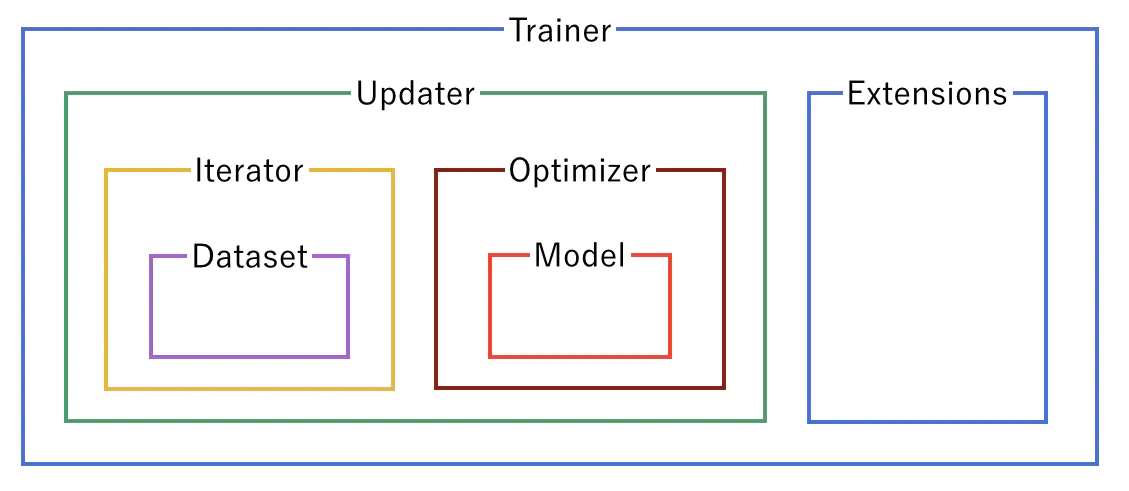

### 4. TrainerにExtensionを追加する

Trainerを使う利点として、

* ログを自動的にファイルに保存（LogReport)
* ターミナルに定期的にロスなどの情報を表示（PrintReport）
* ロスを定期的にグラフで可視化して画像として保存（PlotReport)
* 定期的にモデルやOptimizerの状態を自動シリアライズ（snapshot）
* 学習の進捗を示すプログレスバーを表示（ProgressBar）
* ネットワークの構造をGraphvizのdot形式で保存（dump_graph）
* ネットワークのパラメータの平均や分散などの統計情報を出力（ParameterStatistics）

などなどの様々な便利な機能を簡単に利用することができる点があります。これらの機能を利用するには、Trainerオブジェクトに対してextendメソッドを使って追加したいExtensionのオブジェクトを渡してやるだけです。では実際に幾つかのExtensionを追加してみましょう。

In [22]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=gpu_id), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'l1/W/data/std', 'elapsed_time']))
trainer.extend(extensions.ParameterStatistics(net.predictor.l1, {'std': np.std}))
trainer.extend(extensions.PlotReport(['l1/W/data/std'], x_key='epoch', file_name='std.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

**LogReport**

epochやiterationごとのloss, accuracyなどを自動的に集計し、Trainerのout引数で指定した出力ディレクトリにlogというファイル名で保存します。


**snapshort**

Trainerのout引数で指定した出力ディレクトリにTrainerオブジェクトを指定されたタイミング（デフォルトでは1エポックごと）に保存します。Trainerオブジェクトは上述のようにUpdaterを持っており、この中にOptimizerとモデルが保持されているため、このExtensionでスナップショットをとっておけば、学習の復帰や学習済みモデルを使った推論などが学習終了後にも可能になります。


**dump_graph**

指定されたVariableオブジェクトから辿れる計算グラフをGraphvizのdot形式で保存します。保存先はTrainerのout引数で指定した出力ディレクトリです。


**Evaluator**

評価用のデータセットのIteratorと、学習に使うモデルのオブジェクトを渡しておくことで、学習中のモデルを指定されたタイミングで評価用データセットを用いて評価します。内部では、chainer.config.using_config('train', False)が自動的に行われます。backprop_enableをFalseにすることは行われないため、メモリ使用効率はデフォルトでは最適ではありませんが、基本的にはEvaluatorを使えば評価を行うという点において問題はありません。


**PrintReoprt**

Reporterによって集計された値を標準出力に出力します。このときどの値を出力するかを、リストの形で与えます。


**PlotReport**

引数のリストで指定された値の変遷をmatplotlibライブラリを使ってグラフに描画し、出力ディレクトリにfile_name引数で指定されたファイル名で画像として保存します。


**ParameterStatistics**

指定したレイヤ（Link）が持つパラメータの平均・分散・最小値・最大値などなどの統計情報を計算して、ログに保存します。パラメータが発散していないかなどをチェックするのに便利です。


これらのExtensionは、ここで紹介した以外にも、例えばtriggerによって個別に作動するタイミングを指定できるなどのいくつかのオプションを持っており、より柔軟に組み合わせることができます。詳しくは公式のドキュメントを見てください

### 5. 学習を開始する

学習を開始するには、Trainerオブジェクトのメソッドrunを呼ぶだけです！

In [23]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  l1/W/data/std  elapsed_time
1           1.61897     0.615825       0.880655       0.811313           0.0358874      2.48896       
2           0.6476      0.844349       0.511862       0.864122           0.0365516      5.7386        
3           0.455919    0.879307       0.411937       0.888054           0.0369597      8.99953       
4           0.387199    0.893422       0.366182       0.898536           0.0372169      12.1546       
5           0.351246    0.902174       0.338617       0.904272           0.0374087      16.2516       
6           0.32745     0.906971       0.320286       0.910008           0.0375627      19.9394       
7           0.310032    0.911425       0.303882       0.914755           0.037691       23.3241       
8           0.295756    0.914924       0.291066       0.918018           0.0378086      27.7072       
9           0.2835      0.917799       0.279756       0.920985           0.

初めに取り組んだ学習ループを自分で書いた場合よりもより短いコードで、リッチなログ情報とともに、下記で表示してみるようなグラフなども作りつつ、同様の結果を得ることができました。1層目の全結合層の重み行列の値の標準偏差が、学習の進行とともに徐々に大きくなっていっているのも見て取れて、面白いですね。

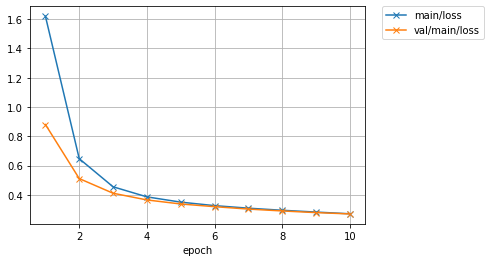

In [24]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

精度のグラフも見てみましょう。

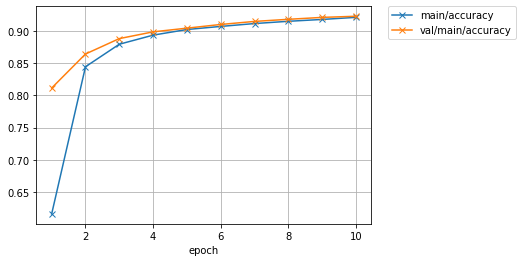

In [25]:
Image(filename='mnist_result/accuracy.png')

もう少し学習を続ければ、まだ多少精度の向上が図れそうな雰囲気がありますね。

ついでに、dump_graphというExtensionが出力した計算グラフを、Graphvizを使って画像化して見てみましょう。

In [26]:
%%cmd
dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

Microsoft Windows [Version 10.0.17763.737]
(c) 2018 Microsoft Corporation. All rights reserved.

(CC4192) C:\Python\MyStudy\NN\Chainer>dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

(CC4192) C:\Python\MyStudy\NN\Chainer>

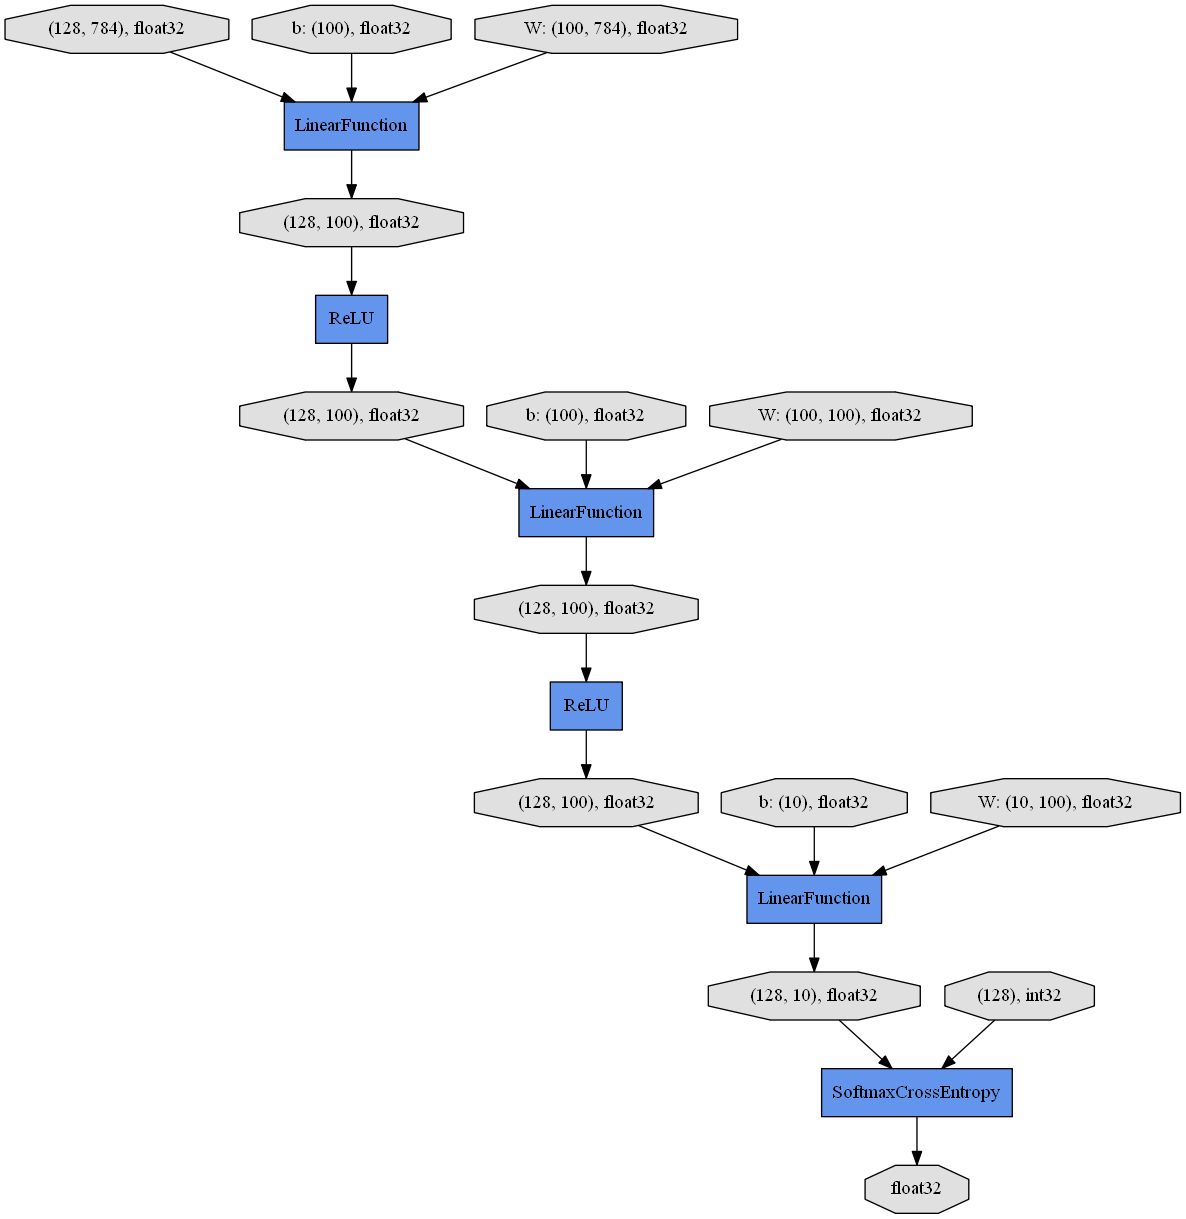

In [27]:
Image(filename='mnist_result/cg.png')

上から下へ向かって、データやパラメータがどのようなFunctionに渡されて計算が行われ、ロスを表すVariableが出力されたかが分かります。

### 6. テストデータで評価する

上でもValidationデータに対しての評価を学習中に行うために使用されているTrainer Extensionの一つであるEvaluatorは、Trainerと関係なく独立して使うこともできます。以下のようにしてIteratorとネットワークのオブジェクト（net）、使用するデバイスIDを渡してEvaluatorオブジェクトを作成し、これを関数として実行するだけです。

In [28]:
test_evaluator = extensions.Evaluator(test_iter, net, device=gpu_id)
results = test_evaluator()
print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.9286985759493671


### 7. 学習済みモデルで推論する

それでは、Trainer Extensionのsnapshotが自動的に保存したネットワークのスナップショットから学習済みパラメータを読み込んで、学習ループを書いて学習したときと同様に1番目のテストデータで推論を行ってみましょう。

ここで注意すべきは、snapshotが保存するnpzファイルはTrainer全体のスナップショットであるため、extensionの内部のパラメータなども一緒に保存されています。これは、学習自体を再開するために必要だからです。しかし、今回はネットワークのパラメータだけを読み込めば良いので、serializers.load_npz()のpath引数にネットワーク部分までのパス（updater/model:main/predictor/）を指定しています。こうすることで、ネットワークのオブジェクトにパラメータだけを読み込むことができます。

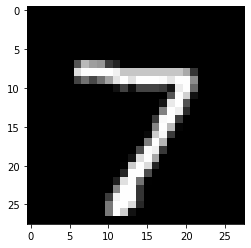

予測ラベル: 7


In [29]:
reset_seed(0)

infer_net = MLP()
serializers.load_npz(
    'mnist_result/snapshot_epoch-10',
    infer_net, path='updater/model:main/predictor/')

if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()

x = infer_net.xp.asarray(x[None, ...])
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(x)
y = to_cpu(y.array)

print('予測ラベル:', y.argmax(axis=1)[0])

## 新しいネットワークを書いてみよう

ここでは、MNISTデータセットではなくCIFAR10という32x32サイズの小さなカラー画像に10クラスのいずれかのラベルがついたデータセットを用いて、いろいろなモデルを自分で書いて試行錯誤する流れを体験してみます。

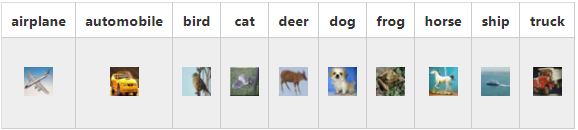								

### 1. ネットワークの定義

ここでは、さきほど試した全結合層だけからなるネットワークではなく、畳込み層を持つネットワークを定義してみます。3つの畳み込み層を持ち、2つの全結合層がそのあとに続いています。

In [30]:
import chainer
import chainer.links as L
import chainer.functions as F

class MyNet(chainer.Chain):

    def __init__(self, n_out):
        super(MyNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 32, 3, 3, 1)
            self.conv2 = L.Convolution2D(32, 64, 3, 3, 1)
            self.conv3 = L.Convolution2D(64, 128, 3, 3, 1)
            self.fc4 = L.Linear(None, 1000)
            self.fc5 = L.Linear(1000, n_out)

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h

### 2. 学習

ここで、あとから別のネットワークも簡単に同じ設定で訓練できるよう、train関数を作っておきます。これは、

* ネットワークのオブジェクト
* バッチサイズ
* 使用するGPU\_ID
* 学習を終了するエポック数
* データセットオブジェクト
* 学習率の初期値
* 学習率減衰のタイミング

などを渡すと、内部でTrainerを用いて渡されたデータセットを使ってネットワークを訓練し、学習が終了した状態のネットワークを返してくれる関数です。Trainer.run()が終了した後に、テストデータセットを使って評価まで行ってくれます。先程のMNISTでの例と違い、最適化手法にはMomentumSGDを用い、ExponentialShiftというExtentionを使って、指定したタイミングごとに学習率を減衰させるようにしてみます。

また、ここではcifar.get_cifar10()が返す学習用データセットのうち9割のデータをtrain、残りの1割をvalidとして使うようにしています。

このtrain関数を用いて、上で定義したMyModelモデルを訓練してみます。

In [31]:
from chainer.datasets import cifar
from chainer import iterators
from chainer.datasets import split_dataset_random
from chainer import optimizers
from chainer import training
from chainer.training import extensions

def train(network_object, batchsize=128, gpu_id=0, max_epoch=20, 
          train_dataset=None, valid_dataset=None, test_dataset=None, 
          postfix='', base_lr=0.01, lr_decay=None):

    # 1. Dataset
    if train_dataset is None and valid_dataset is None and test_dataset is None:
        train_val, test = cifar.get_cifar10()
        train_size = int(len(train_val) * 0.9)
        train, valid = split_dataset_random(train_val, train_size, seed=0)
    else:
        train, valid, test = train_dataset, valid_dataset, test_dataset

    # 2. Iterator
    train_iter = iterators.MultiprocessIterator(train, batchsize)
    valid_iter = iterators.MultiprocessIterator(valid, batchsize, False, False)

    # 3. Model
    net = L.Classifier(network_object)

    # 4. Optimizer
    optimizer = optimizers.MomentumSGD(lr=base_lr).setup(net)
    optimizer.add_hook(chainer.optimizer.WeightDecay(0.0005))

    # 5. Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_cifar10_{}result'.format(network_object.__class__.__name__, postfix))

    # 7. Trainer extensions
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.observe_lr())
    trainer.extend(extensions.Evaluator(valid_iter, net, device=gpu_id), name='val')
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time', 'lr']))
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    if lr_decay is not None:
        trainer.extend(extensions.ExponentialShift('lr', 0.1), trigger=lr_decay)
    trainer.run()
    del trainer

    # 8. Evaluation
    test_iter = iterators.MultiprocessIterator(test, batchsize, False, False)
    test_evaluator = extensions.Evaluator(test_iter, net, device=gpu_id)
    results = test_evaluator()
    print('Test accuracy:', results['main/accuracy'])

    return net

In [32]:
# net = train(MyNet(10), gpu_id=0) # GPU
net = train(MyNet(10), gpu_id=-1) # CPU

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time  lr        
1           1.9669      0.289728       1.74513        0.39375            104.564       0.01        
2           1.6279      0.417347       1.596          0.43418            178.441       0.01        
3           1.48762     0.464031       1.46121        0.480273           263.97        0.01        
4           1.39053     0.49858        1.3681         0.52207            334.989       0.01        
5           1.33015     0.520856       1.34633        0.519922           423.541       0.01        
6           1.26975     0.542769       1.29068        0.545312           534.308       0.01        
7           1.21847     0.564325       1.28839        0.543359           632.148       0.01        
8           1.17277     0.581077       1.22994        0.561133           728.576       0.01        
9           1.12207     0.59992        1.2302         0.563672           829.374       0.01        
10

学習が20エポックまで終わりました。ロスと精度のプロットを見てみましょう。

In [1]:
Image(filename='MyNet_cifar10_result/loss.png')

NameError: name 'Image' is not defined

In [ ]:
Image(filename='MyNet_cifar10_result/accuracy.png')

学習データでの精度（main/accuracy)は77%程度まで到達していますが、テストデータでのロス（val/main/loss）は途中から下げ止まり、精度（val/main/accuracy）も60%前後で頭打ちになってしまっています。表示されたログの最後の行を見ると、テストデータでの精度も同様に60%程度だったようです。学習データでは良い精度が出ているが、 テストデータでは精度が良くないということなので、モデルが学習データにオーバーフィッティングしていると思われます。

### 3. 学習済みネットワークを使った予測

テスト精度は60%程度でしたが、試しにこの学習済みネットワークを使っていくつかのテスト画像を分類させてみましょう。あとで使いまわせるようにpredict関数を作っておきます。

In [ ]:
cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']

def predict(net, image_id):
    _, test = cifar.get_cifar10()
    x, t = test[image_id]
    net.to_cpu()
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y = net.predictor(x[None, ...]).data.argmax(axis=1)[0]
    print('predicted_label:', cls_names[y])
    print('answer:', cls_names[t])

    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

for i in range(10, 15):
    predict(net, i)

うまく分類できているものもあれば、そうでないものもありました。ネットワークの学習に使用したデータセット上ではほぼ百発百中で正解できるとしても、未知のデータ、すなわちテストデータセットにある画像に対して高精度な予測ができなければ、意味がありません2。テストデータでの精度は、モデルの汎化性能に関係していると言われます。

どうすれば高い汎化性能を持つネットワークを設計し、学習することができるでしょうか？
（そんなことが簡単に分かったら苦労しない。）

### 4. もっと深いネットワークを定義してみよう

では、上のネットワークよりもよりたくさんの層を持つネットワークを定義してみましょう。ここでは、1層の畳み込みネットワークをConvBlock、1層の全結合ネットワークをLinearBlockとして定義し、これをたくさんシーケンシャルに積み重ねる方法で大きなネットワークを定義してみます。

#### 構成要素を定義する

まず、今目指している大きなネットワークの構成要素となるConvBlockとLinearBlockを定義してみましょう。

In [ ]:
class ConvBlock(chainer.Chain):

    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(None, n_ch, 3, 1, 1, nobias=True, initialW=w)
            self.bn = L.BatchNormalization(n_ch)
        self.pool_drop = pool_drop

    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25)
        return h

class LinearBlock(chainer.Chain):

    def __init__(self, drop=False):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc = L.Linear(None, 1024, initialW=w)
        self.drop = drop

    def __call__(self, x):
        h = F.relu(self.fc(x))
        if self.drop:
            h = F.dropout(h)
        return h

ConvBlockはChainを継承した小さなネットワークとして定義されています。これは一つの畳み込み層とBatch Normalization層をパラメータありで持っているので、コンストラクタ内でこれらの登録を行っています。__call__メソッドでは、これらにデータを渡しつつ、活性化関数ReLUを適用して、さらにpool_dropがコンストラクタにTrueで渡されているときはMax PoolingとDropoutという関数を適用するようになっています。

Chainerでは、Pythonを使って書いたforward計算のコード自体がネットワークの構造を表します。すなわち、実行時にデータがどのような層をくぐっていったか、ということがネットワークそのものを定義します。これによって、上記のような分岐などを含むネットワークも簡単に書け、柔軟かつシンプルで可読性の高いネットワーク定義が可能になります。これがDefine-by-Runと呼ばれる特徴です。

#### 大きなネットワークの定義

次に、これらの小さなネットワークを構成要素として積み重ねて、大きなネットワークを定義してみましょう。

In [ ]:
class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )

    def __call__(self, x):
        for f in self:
            x = f(x)
        return x

ここで利用しているのが、ChainListというクラスです。このクラスはChainを継承したクラスで、いくつものLinkやChainを順次呼び出していくようなネットワークを定義するときに便利です。ChainListを継承して定義されるモデルは、親クラスのコンストラクタを呼び出す際にキーワード引数ではなく普通の引数としてLinkもしくはChainオブジェクトを渡すことができます。そしてこれらは、self.children()メソッドによって登録した順番に取り出すことができます。ChainList自体もPythonのイテレータとして機能するので、例えばChainListを継承したクラスの中でfor f in self:...といったことも可能です。

この特徴を使うと、forward計算の記述が簡単になります。self.children()が返す構成要素のリストから、for文で構成要素を順番に取り出していき、そもそもの入力であるxに取り出してきた部分ネットワークの計算を適用して、この出力でxを置き換えるということを順番に行っていけば、一連のLinkまたはChainを、コンストラクタで親クラスに登録した順番と同じ順番で適用していくことができます。そのため、シーケンシャルな部分ネットワークの適用によって表される大きなネットワークを定義するのに重宝します。

それでは、学習を回してみます。今回はパラメータ数も多いので、学習を停止するエポック数を100に設定します。また、学習率を0.1から始めて、30エポックごとに10分の1にするように設定してみます。

**TIPS**

今回は多くの畳込み層を使う大きなネットワークを使うので、Chainerが用意してくれているcuDNNのautotune機能を有効可してみます。やり方は簡単で、以下の二行を事前に実行しておくだけです。

In [ ]:
chainer.cuda.set_max_workspace_size(512 * 1024 * 1024)
chainer.config.autotune = True

それでは、今度こそ学習を開始してみましょう。

In [ ]:
reset_seed(0)

#model = train(DeepCNN(10), max_epoch=100, base_lr=0.1, lr_decay=(30, 'epoch'))
model = train(DeepCNN(10), gpu_id=-1, max_epoch=100, base_lr=0.1, lr_decay=(30, 'epoch'))

学習が終了しました。ロスカーブと精度のグラフを見てみましょう。

In [1]:
Image(filename='DeepCNN_cifar10_result/loss.png')

NameError: name 'Image' is not defined

In [ ]:
Image(filename='DeepCNN_cifar10_result/accuracy.png')

先程よりも大幅にValidationデータに対する精度が向上したことが分かります。学習率を10分の1に下げるタイミングでロスががくっと減り、精度がガクッと上がっているのが分かります。最終的に、先程60%前後だったValidationデータでの精度が、90%程度まで上がりました。また、テストデータを用いた精度も、およそ90%程度となっています。しかし最新の研究成果では97%以上まで達成されています。さらに精度を上げるには、今回行ったようなネットワークの構造自体の改良ももちろんのこと、学習データを擬似的に増やす操作（Data augmentation）や、複数のモデルの出力を一つの出力に統合する操作（Ensemble）などなど、いろいろな工夫が考えられます。

# データセットクラスを書いてみよう

ここでは、Chainerにすでに用意されているCIFAR10のデータを取得する機能を使って、データセットクラスを自分で書いてみます。Chainerでは、データセットを表すクラスは以下の機能を持っていることが必要とされます。

* データセット内のデータ数を返す__len__メソッド
* 引数として渡されるiに対応したデータもしくはデータとラベルの組を返すget_exampleメソッド

その他のデータセットに必要な機能は、chainer.dataset.DatasetMixinクラスを継承することで用意できます。ここでは、DatasetMixinクラスを継承し、Data augmentation機能のついたデータセットクラスを作成してみましょう。

**NOTE**

自前で用意した、もしくはどこからから調達したラベル付き画像データセットを使う場合は、LabeledImageDatasetというクラスが非常に便利です。詳細はドキュメントを参照してください：LabeledImageDataset。こちらでも使っています：Chainerでアニメキャラクターの顔画像を分類する

## 1. CIFAR10データセットクラスを書く

In [ ]:
class CIFAR10Augmented(chainer.dataset.DatasetMixin):

    def __init__(self, split='train', train_ratio=0.9):
        train_val, test_data = cifar.get_cifar10()
        train_size = int(len(train_val) * train_ratio)
        train_data, valid_data = split_dataset_random(train_val, train_size, seed=0)
        if split == 'train':
            self.data = train_data
        elif split == 'valid':
            self.data = valid_data
        elif split == 'test':
            self.data = test_data
        else:
            raise ValueError("'split' argument should be either 'train', 'valid', or 'test'. But {} was given.".format(split))

        self.split = split
        self.random_crop = 4

    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        x, t = self.data[i]
        if self.split == 'train':
            x = x.transpose(1, 2, 0)
            h, w, _ = x.shape
            x_offset = np.random.randint(self.random_crop)
            y_offset = np.random.randint(self.random_crop)
            x = x[y_offset:y_offset + h - self.random_crop,
                  x_offset:x_offset + w - self.random_crop]
            if np.random.rand() > 0.5:
                x = np.fliplr(x)
            x = x.transpose(2, 0, 1)

        return x, t

このクラスは、CIFAR10のデータのそれぞれに対し、

* 32x32の大きさの中からランダムに28x28の領域をクロップ
* 1/2の確率で左右を反転させる

という加工を行っています。こういった操作を加えることで擬似的に学習データのバリエーションを増やすと、オーバーフィッティングを抑制することに役に立つということが知られています。これらの操作以外にも、画像の色味を変化させるような変換やランダムな回転、アフィン変換など、さまざまな加工によって学習データ数を擬似的に増やす方法が提案されています。

自分でデータの取得部分も書く場合は、コンストラクタに画像フォルダのパスとファイル名に対応したラベルの書かれたテキストファイルへのパスなどを渡してプロパティとして保持しておき、get_exampleメソッド内でそれぞれの画像を読み込んで対応するラベルとともに返す、という風にすれば良いことが分かります。

## 2. 作成したデータセットクラスを使って学習を行う

それではさっそくこのCIFAR10クラスを使って学習を行ってみましょう。先程使ったのと同じ大きなネットワークを使うことで、Data augmentationの効果がどの程度あるのかを調べてみましょう。train関数も含め、データセットクラス以外は先程とすべて同様です。

In [ ]:
reset_seed(0)

model = train(DeepCNN(10), max_epoch=100, train_dataset=CIFAR10Augmented(), 
              valid_dataset=CIFAR10Augmented('valid'), 
              test_dataset=CIFAR10Augmented('test'), 
              postfix='augmented_', base_lr=0.1, lr_decay=(30, 'epoch'))

先程のData augmentationなしの場合は90%程度だったテスト精度が、学習データにaugmentationを施すことで92%程度まで向上させられることが分かりました。およそ2%の改善です。

ロスと精度のグラフを見てみましょう。

In [ ]:
Image(filename='DeepCNN_cifar10_augmented_result/loss.png')

In [ ]:
Image(filename='DeepCNN_cifar10_augmented_result/accuracy.png')

# もっと簡単にData Augmentationしよう

前述のようにデータセット内の各画像についていろいろな変換を行って擬似的にデータを増やすような操作をData Augmentationといいます。上では、オリジナルのデータセットクラスを作る方法を示すために変換の操作もget_example()内に書くという実装を行いましたが、実はもっと簡単にいろいろな変換をデータに対して行う方法があります。

それは、TransformDatasetクラスを使う方法です。TransformDatasetは、元になるデータセットオブジェクトと、そこからサンプルしてきた各データ点に対して行いたい変換を関数の形で与えると、変換済みのデータを返してくれるようなデータセットオブジェクトに加工してくれる便利なクラスです。かんたんな使い方は以下です。

In [ ]:
from chainer.datasets import TransformDataset

train_val, test_dataset = cifar.get_cifar10()
train_size = int(len(train_val) * 0.9)
train_dataset, valid_dataset = split_dataset_random(train_val, train_size, seed=0)


# 行いたい変換を関数の形で書く
def transform(inputs):
    x, t = inputs
    x = x.transpose(1, 2, 0)
    h, w, _ = x.shape
    x_offset = np.random.randint(4)
    y_offset = np.random.randint(4)
    x = x[y_offset:y_offset + h - 4,
          x_offset:x_offset + w - 4]
    if np.random.rand() > 0.5:
        x = np.fliplr(x)
    x = x.transpose(2, 0, 1)

    return x, t


# 各データをtransformにくぐらせたものを返すデータセットオブジェクト
train_dataset = TransformDataset(train_dataset, transform)

このようにすると、この新しいtrain_datasetは、上で自分でデータセットクラスごと書いたときと同じような変換を行った上でデータを返してくれるデータセットオブジェクトになります。

# ChainerCVでいろいろな変換を簡単に行おう

さて、上では画像に対してランダムクロップと、ランダムに左右反転というのをやりました。もっと色々な変換を行いたい場合、上記のtransform関数に色々な処理を追加していけばよいことになりますが、毎回使いまわすような変換処理をそのたびに書くのは面倒です。何かいいライブラリとか無いのかな、となります。そこでChainerCV[Niitani 2017]です！今年のACM MultimediaのOpen Source Software CompetitionにWebDNN[Hidaka 2017]とともに出場していたChainerにComputer Vision向けの便利な機能を色々追加する補助パッケージ的なオープンソース・ソフトウェアです。

%%cmd
pip install chainercv

ChainerCVには、画像に対する様々な変換があらかじめ用意されています。

* [ChainerCVで使える画像変換一覧](https://chainercv.readthedocs.io/en/stable/reference/transforms.html#image)

そのため、上でNumPyを使ってごにょごにょ書いていたランダムクロップやランダム左右反転は、chainercv.transformsモジュールを使うと、それぞれ以下のように1行で書くことができます：

x = transforms.random_crop(x, (28, 28))  # ランダムクロップ
x = chainercv.transforms.random_flip(x)  # ランダム左右反転

chainercv.transformsモジュールを使って、transform関数をアップデートしてみましょう。ちなみに、get_cifar10()で得られるデータセットでは、デフォルトで画像の画素値の範囲が[0, 1]にスケールされています。しかし、get_cifar10()にscale=255.を渡しておくと、値の範囲をもともとの[0, 255]のままにできます。今回transformの中で行う処理は、以下の5つです：

1. PCA lighting: これは大雑把に言えば、少しだけ色味を変えるような変換です
2. Standardization: 訓練用データセット全体からチャンネルごとの画素値の平均・標準偏差を求めて標準化をします
3. Random flip: ランダムに画像の左右を反転します
4. Random expand: [1, 1.5]からランダムに決めた大きさの黒いキャンバスを作り、その中のランダムな位置へ画像を配置します
5. Random crop: (28, 28)の大きさの領域をランダムにクロップします

In [ ]:
from functools import partial
from chainercv import transforms

train_val, test_dataset = cifar.get_cifar10(scale=255.)
train_size = int(len(train_val) * 0.9)
train_dataset, valid_dataset = split_dataset_random(train_val, train_size, seed=0)

mean = np.mean([x for x, _ in train_dataset], axis=(0, 2, 3))
std = np.std([x for x, _ in train_dataset], axis=(0, 2, 3))


def transform(inputs, train=True):
    img, label = inputs
    img = img.copy()

    # Color augmentation
    if train:
        img = transforms.pca_lighting(img, 76.5)

    # Standardization
    img -= mean[:, None, None]
    img /= std[:, None, None]

    # Random flip & crop
    if train:
        img = transforms.random_flip(img, x_random=True)
        img = transforms.random_expand(img, max_ratio=1.5)
        img = transforms.random_crop(img, (28, 28))

    return img, label

train_dataset = TransformDataset(train_dataset, partial(transform, train=True))
valid_dataset = TransformDataset(valid_dataset, partial(transform, train=False))
test_dataset = TransformDataset(test_dataset, partial(transform, train=False))

ちなみに、pca_lightingは、大雑把にいうと色味を微妙に変えた画像を作ってくれる関数です。

では、standardizationとChainerCVによるPCA Lightingを追加したTransformDatasetを使って学習をしてみましょう。

In [ ]:
reset_seed(0)

model = train(DeepCNN(10), max_epoch=100, train_dataset=train_dataset, 
              valid_dataset=valid_dataset, test_dataset=test_dataset, 
              postfix='augmented2_', base_lr=0.1, lr_decay=(30, 'epoch'))

わずかに精度が向上しました。他にもネットワークにResNetと呼ばれる有名なアーキテクチャを採用するなど、簡単に試せる改善方法がいくつかあります。ぜひご自分で色々と試してみてください。

### 脚注

cudnnenvは好きなバージョンのcuDNNを簡単に持ってこれるツールです。pip install cudnnenvでインストールし、こちらにあるインストラクションに従えば、簡単にいろいろなCUDAバージョン向けの様々なバージョンのcuDNNをインストールすることができます。使い方もこちらのREADMEに書いてあるとおり、単純明快です。

学習データに対する予測精度は、もし学習データから抜き出されたあるデータをクエリとし、それが含まれている学習データセットから検索して発見することが必ずできるならば、そのデータについているラベルを答えることで、100%になってしまいます。